In [14]:
import networkx as nx
import numpy as np
import pickle
from parser import *
import os
import matplotlib.pyplot as plt

In [15]:
MERAs_fn = "MERAs_64_disorder.p"
data_dir = "../data/last_few_bits_L_64_energy_avg/"
W_list = range(1,11)
num_files = 100

In [16]:
def load_diagnostics(fname):
    E_dict = {}
    with open(fname, 'r') as fp:
        data = fp.readlines()[-1].split()
        E, var, EE = float(data[2]), float(data[3]), float(data[4])
    return E, var, EE

In [17]:
W_info = {}
for W in W_list:
    i_list   = []
    for i in range(num_files):
        d = "{}W_{}/".format(data_dir, W)
        fname = "{}W_{}_{:02}.txt".format(d, W, i)
        E, var, EE = load_diagnostics(fname)
        i_list.append([E, var, EE])
    W_info[W] = i_list

<IPython.core.display.Javascript object>


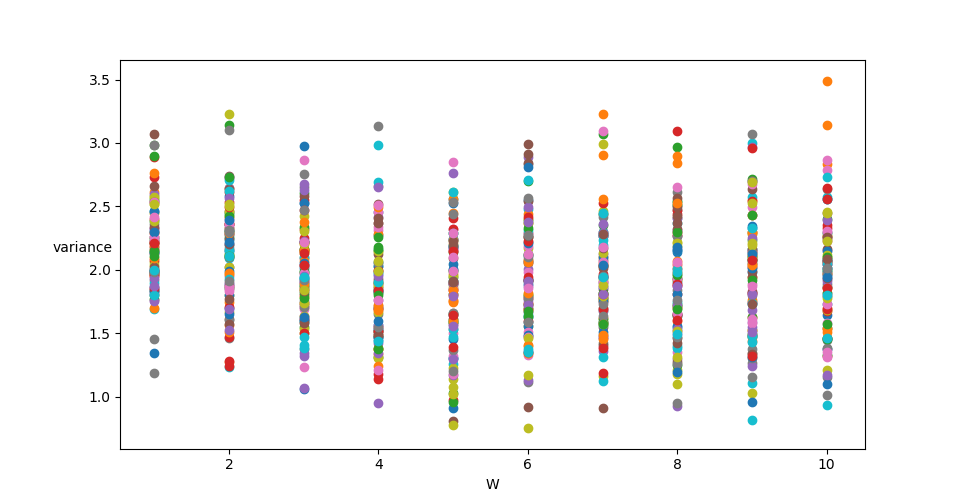

In [27]:
%matplotlib notebook
for W in W_list:
    i_list = W_info[W]
    for E, var, EE in i_list:
        plt.scatter(W, var)
plt.xlabel("W")
plt.ylabel('variance', rotation=0)
plt.show()
    

In [134]:
def get_gaps(N, n):
    gap_means = []
    gap_stds = []
    for W in W_list:
        E_W = W_info[W]
        i_list = []
        for i in range(num_files):
            E_dict = E_W[i]
            E_list = E_dict[N]
            E_diffs = np.abs(np.array(E_list[1:]) - np.array(E_list[:-1]))
            #print(E_diffs)
            gap_stats = [min(E_diffs[i:i+2])/max(E_diffs[i:i+2])for i in range(len(E_diffs)-2)]
            if gap_stats[n] <= 1 and gap_stats[n] >=0:
                i_list.append(gap_stats[n])
            #i_list += [g for g in gap_stats if g <= 1 and g >= 0]
        gap_means.append(np.mean(i_list))
        gap_stds.append(np.std(i_list)/np.sqrt(len(i_list)))
    return gap_means, gap_stds
        

/home/abid/.local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


<IPython.core.display.Javascript object>


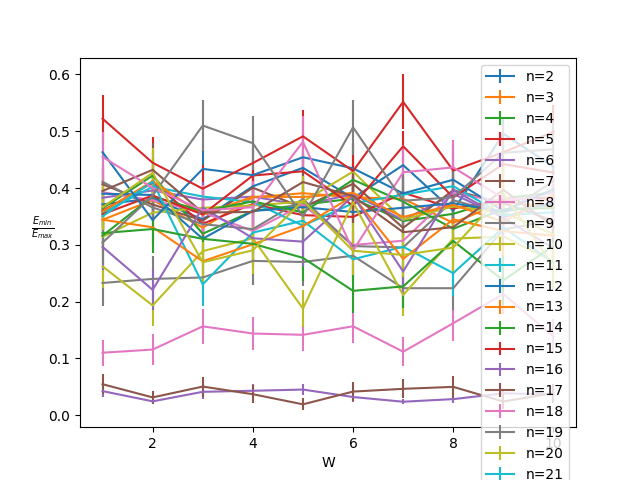

In [137]:
%matplotlib notebook
N = 5
for n in range(2**N-3):
    gap_means, gap_stds = get_gaps(N,n)
    plt.errorbar(W_list, gap_means, yerr=gap_stds, label="n={}".format(n+2))
plt.legend(loc='best')
plt.xlabel("W")
plt.ylabel(r"$\frac{E_{min}}{E_{max}}$", rotation=0)
plt.show()